# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find the best location for a restaurant. Specifically, this report will be targeted to restaurant joints interested in opening any **Restaurant** in **Scarborough**, Toronto, Canada.

Neighborhoods will be filtered based on the **popularity of restaurants** in that particular neighborhood and also on the **overall popularity** of the neighborhood.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood and their popularity
* number of and popularity of other economic businesses in the neighborhood
* distance of neighborhood center from bus stop

This projects uses the the postal code locations as the locality centers of the city to define the neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be obtained from **Wikipedia** and the Geospatial coordinates of boroughs in Toronto provided by Coursera
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**


#### <a href="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M">Wikipedia Postal Codes</a>
The data is of the format of a table in html which will be parsed. For each postal code the latitude and longitude will be retreived from the csv file.

#### Foursquare API
This api will be used to retrieve the restaurant information.


## Postal Codes
The postal codes for neighborhood candiates are found from Wikipedia

Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import bs4
import requests

In [2]:
result = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = bs4.BeautifulSoup(result.content)

In [3]:
table = soup.find('table', class_="wikitable")

Going through all the rows

In [4]:
rows = []
columns = ["PostalCode", "Borough", "Neighborhood"]
for tr in table.find_all('tr'):
    row = []
    for td in tr.find_all('td'):
        row.append(td.get_text().strip())
    if len(row) > 0 and row[1] != "Not assigned":
        rows.append(pd.DataFrame([row], columns=columns))
df = pd.concat(rows, ignore_index=True)

In [5]:
df.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


Removing Not assigned neighborhoods

In [6]:
df["Neighborhood"] = np.where(df["Neighborhood"] == "Not assigned", df["Borough"], df["Neighborhood"])

In [7]:
def concatenate(series):
    return ",".join(series)
df = df.groupby('PostalCode').agg({'Borough': 'first', 'Neighborhood': concatenate}).sort_values("PostalCode")

### Loading Geospatial Coordinates

In [8]:
lat_lng_df = pd.read_csv('./Geospatial_Coordinates.csv')

In [9]:
canadian_df = df.join(lat_lng_df.set_index("Postal Code"))
scarborough_df = canadian_df[canadian_df['Borough'].str.contains("Scarborough")]

In [10]:
canadian_df.head()

,Borough,Neighborhood,Latitude,Longitude
PostalCode,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [11]:
scarborough_df

,Borough,Neighborhood,Latitude,Longitude
PostalCode,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
M1G,Scarborough,Woburn,43.770992,-79.216917
M1H,Scarborough,Cedarbrae,43.773136,-79.239476
M1J,Scarborough,Scarborough Village,43.744734,-79.239476
M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476


In [12]:
import folium

In [13]:
map_scarborough = folium.Map(location=[43.7634618, -79.368819], zoom_start=11)

# add markers to map
for lat, lng, label in zip(scarborough_df['Latitude'], scarborough_df['Longitude'], scarborough_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_scarborough)  
    
map_scarborough

In [14]:
# removed due to security reasons

A Utility function to get nearby venues

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
scarborough_venues = getNearbyVenues(names=scarborough_df['Neighborhood'],
                                   latitudes=scarborough_df['Latitude'],
                                   longitudes=scarborough_df['Longitude']
                                  )

Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge


Checking for the sanity of the venues

In [17]:
print(scarborough_venues.shape)
scarborough_venues.head(20)

(79, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,4c23d3aaf7ced13a5ed7216d,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,5898005b76b8b25854c36663,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4b6074e3f964a5200fe729e3,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4c62f34bde1b2d7fec89e370,G & G Electronics,43.765309,-79.191537,Electronics Store
5,"Guildwood,Morningside,West Hill",43.763573,-79.188711,5411f741498e9ebd5e35d8bd,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
6,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4c1c7f9bb306c9288f0464b7,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
7,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4b9008acf964a520737133e3,Woburn Medical Centre,43.766631,-79.192286,Medical Center
8,"Guildwood,Morningside,West Hill",43.763573,-79.188711,513b84e6e4b0ef935943c0ad,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
9,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4d95bd2ddaec224bf7bf043e,Eggsmart,43.767800,-79.190466,Breakfast Spot


In [18]:
scarborough_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Agincourt,4,4,4,4,4,4,4
"Agincourt North,L'Amoreaux East,Milliken,Steeles East",2,2,2,2,2,2,2
"Birch Cliff,Cliffside West",4,4,4,4,4,4,4
Cedarbrae,8,8,8,8,8,8,8
"Clairlea,Golden Mile,Oakridge",9,9,9,9,9,9,9
"Clarks Corners,Sullivan,Tam O'Shanter",10,10,10,10,10,10,10
"Cliffcrest,Cliffside,Scarborough Village West",2,2,2,2,2,2,2
"Dorset Park,Scarborough Town Centre,Wexford Heights",6,6,6,6,6,6,6
"East Birchmount Park,Ionview,Kennedy Park",4,4,4,4,4,4,4


Converting the venue category to one hot columns

In [19]:
# one hot encoding
scarborough_onehot = pd.get_dummies(scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
scarborough_onehot['Neighborhood'] = scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [scarborough_onehot.columns[-1]] + list(scarborough_onehot.columns[:-1])
scarborough_onehot = scarborough_onehot[fixed_columns]

scarborough_onehot.head()

,Neighborhood,American Restaurant,Athletics & Sports,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,...,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Vietnamese Restaurant
0,"Rouge,Malvern",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Highland Creek,Rouge Hill,Port Union",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,"Guildwood,Morningside,West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouping by Neighborhood

In [20]:
scarborough_grouped = scarborough_onehot.groupby('Neighborhood').mean().reset_index()
scarborough_grouped

,Neighborhood,American Restaurant,Athletics & Sports,Bakery,Bank,Bar,Breakfast Spot,Bus Line,Bus Station,Café,...,Pharmacy,Pizza Place,Playground,Rental Car Location,Sandwich Place,Skating Rink,Smoke Shop,Soccer Field,Thai Restaurant,Vietnamese Restaurant
0,Agincourt,0.0,0.000,0.000000,0.000,0.0,0.250000,0.000000,0.000000,0.00,...,0.00,0.000000,0.0,0.000000,0.0,0.25,0.00,0.000000,0.000,0.000000
1,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.0,0.000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.00,...,0.00,0.000000,0.5,0.000000,0.0,0.00,0.00,0.000000,0.000,0.000000
2,"Birch Cliff,Cliffside West",0.0,0.000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.25,...,0.00,0.000000,0.0,0.000000,0.0,0.25,0.00,0.000000,0.000,0.000000
3,Cedarbrae,0.0,0.125,0.125000,0.125,0.0,0.000000,0.000000,0.000000,0.00,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.125,0.000000
4,"Clairlea,Golden Mile,Oakridge",0.0,0.000,0.111111,0.000,0.0,0.000000,0.222222,0.111111,0.00,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.00,0.111111,0.000,0.000000
5,"Clarks Corners,Sullivan,Tam O'Shanter",0.0,0.000,0.000000,0.100,0.0,0.000000,0.000000,0.000000,0.00,...,0.10,0.200000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.100,0.000000
6,"Cliffcrest,Cliffside,Scarborough Village West",0.5,0.000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.00,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000,0.000000
7,"Dorset Park,Scarborough Town Centre,Wexford He...",0.0,0.000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.00,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000,0.166667
8,"East Birchmount Park,Ionview,Kennedy Park",0.0,0.000,0.000000,0.000,0.0,0.000000,0.000000,0.000000,0.00,...,0.00,0.000000,0.0,0.000000,0.0,0.00,0.00,0.000000,0.000,0.000000
9,"Guildwood,Morningside,West Hill",0.0,0.000,0.000000,0.000,0.0,0.142857,0.000000,0.000000,0.00,...,0.00,0.142857,0.0,0.142857,0.0,0.00,0.00,0.000000,0.000,0.000000


Getting frequency of Venue Categories and displaying them

In [21]:
num_top_venues = 5

for hood in scarborough_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = scarborough_grouped[scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                 venue  freq
0               Lounge  0.25
1       Breakfast Spot  0.25
2         Skating Rink  0.25
3       Clothing Store  0.25
4  American Restaurant  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
                       venue  freq
0                       Park   0.5
1                 Playground   0.5
2               Noodle House   0.0
3          Korean Restaurant   0.0
4  Latin American Restaurant   0.0


----Birch Cliff,Cliffside West----
                   venue  freq
0        College Stadium  0.25
1           Skating Rink  0.25
2  General Entertainment  0.25
3                   Café  0.25
4                   Park  0.00


----Cedarbrae----
                venue  freq
0              Lounge  0.12
1              Bakery  0.12
2                Bank  0.12
3     Thai Restaurant  0.12
4  Athletics & Sports  0.12


----Clairlea,Golden Mile,Oakridge----
          venue  freq
0      Bus Line  0.22
1        Bakery  0.11
2  Intersection  

Getting most Common Venue

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = scarborough_grouped['Neighborhood']

for ind in np.arange(scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Skating Rink,Breakfast Spot,Lounge,Clothing Store,Vietnamese Restaurant,Coffee Shop,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
1,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Playground,Park,Vietnamese Restaurant,Clothing Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Department Store,Cosmetics Shop
2,"Birch Cliff,Cliffside West",General Entertainment,Skating Rink,Café,College Stadium,Vietnamese Restaurant,Coffee Shop,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Electronics Store
3,Cedarbrae,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Lounge,Caribbean Restaurant,Hakka Restaurant,Convenience Store,Grocery Store
4,"Clairlea,Golden Mile,Oakridge",Bus Line,Soccer Field,Bakery,Intersection,Fast Food Restaurant,Bus Station,Park,Metro Station,Vietnamese Restaurant,College Stadium


Merging the original dataframe with the sorted venues

In [24]:
scarborough_merged = scarborough_df

# merge scarborough_grouped with scarborough_data to add latitude/longitude for each neighborhood
scarborough_merged = scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# anomalus entry
scarborough_merged.drop(['M1X'], inplace=True)
scarborough_merged.head()

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
PostalCode,,,,,,,,,,,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Fast Food Restaurant,Vietnamese Restaurant,Hobby Shop,Grocery Store,General Entertainment,Fried Chicken Joint,Electronics Store,Department Store,Cosmetics Shop,Convenience Store
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Moving Target,Bar,Vietnamese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Department Store,Cosmetics Shop
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Intersection,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Medical Center,Mexican Restaurant,Vietnamese Restaurant,Coffee Shop,Fried Chicken Joint
M1G,Scarborough,Woburn,43.770992,-79.216917,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Department Store
M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Lounge,Caribbean Restaurant,Hakka Restaurant,Convenience Store,Grocery Store


A Utility function to find the number of likes for a given venueId from Foursquare

In [25]:
def getLikes(venueIds):
    
    venues_list=[]
    columns = ['Venue Id', 'Likes']
            
    # create the API request URL
    for venueId in venueIds:
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
            venueId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
        results = requests.get(url).json()["response"]
        result = results['likes']['count']
        print(venueId, result)
        # return only relevant information for each nearby venue
        venues_list.append(pd.DataFrame([[venueId, result]], columns=columns))

    venues_likes = pd.concat(venues_list, ignore_index=True)
    
    return(venues_likes)

In [26]:
venue_likes = getLikes(scarborough_venues['Venue Id'])
venue_likes

4bb6b9446edc76b0d771311c 1
4c23d3aaf7ced13a5ed7216d 1
5898005b76b8b25854c36663 0
4b6074e3f964a5200fe729e3 10
4c62f34bde1b2d7fec89e370 1
5411f741498e9ebd5e35d8bd 2
4c1c7f9bb306c9288f0464b7 0
4b9008acf964a520737133e3 1
513b84e6e4b0ef935943c0ad 0
4d95bd2ddaec224bf7bf043e 4
4cc1d28c06c254815ac18547 1
5164bf50e4b0ca7ab1d9ed8b 0
4de0403ed4c040523ea079f4 0
51678330e4b0ee56c2901e01 0
4b1711a6f964a520cbc123e3 47
4e261f261f6eb1ae13930699 18
4c27da423492a593158cb628 4
4b931d41f964a520d43534e3 7
4cf987f9c6cca35d2d988032 1
4e42cfc56284d1faa44a1083 7
4cddfe25db125481ff0b2ece 5
53a66329498ea26469816eb2 1
5150a8dae4b045dfb6581c85 0
50942b90e4b0a70261f30d18 0
4b6a37ccf964a520a5cd2be3 9
4c6aa500c946e21ec432ed8e 8
555d2742498e3524508bc7c6 1
4bd325219854d13aa0fafc4d 0
4bc8e605b6c49c740e5b8d91 9
4f9a23a7e4b01cdc44fe1c04 0
4d6baccf6107f04d5a94317a 4
4aef7f5ff964a520e4d821e3 7
4cdefc973644a0931fa84f9f 0
516f1db2e4b037c43004ba18 1
4cb6527eb315a0934c469b76 2
4fe26c39e4b00dcb4e287fb0 1
4cae70b639458cfa10d3f29f 

,Venue Id,Likes
0,4bb6b9446edc76b0d771311c,1
1,4c23d3aaf7ced13a5ed7216d,1
2,5898005b76b8b25854c36663,0
3,4b6074e3f964a5200fe729e3,10
4,4c62f34bde1b2d7fec89e370,1
5,5411f741498e9ebd5e35d8bd,2
6,4c1c7f9bb306c9288f0464b7,0
7,4b9008acf964a520737133e3,1
8,513b84e6e4b0ef935943c0ad,0
9,4d95bd2ddaec224bf7bf043e,4


Merging the likes of venues with the venue dataframe

In [27]:
scarborough_venues = pd.merge(scarborough_venues, venue_likes, on='Venue Id')

In [28]:
scarborough_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Category,Likes
0,"Rouge,Malvern",43.806686,-79.194353,4bb6b9446edc76b0d771311c,Wendy's,43.807448,-79.199056,Fast Food Restaurant,1
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,4c23d3aaf7ced13a5ed7216d,Royal Canadian Legion,43.782533,-79.163085,Bar,1
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,5898005b76b8b25854c36663,Affordable Toronto Movers,43.787919,-79.162977,Moving Target,0
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4b6074e3f964a5200fe729e3,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place,10
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4c62f34bde1b2d7fec89e370,G & G Electronics,43.765309,-79.191537,Electronics Store,1
5,"Guildwood,Morningside,West Hill",43.763573,-79.188711,5411f741498e9ebd5e35d8bd,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant,2
6,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4c1c7f9bb306c9288f0464b7,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location,0
7,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4b9008acf964a520737133e3,Woburn Medical Centre,43.766631,-79.192286,Medical Center,1
8,"Guildwood,Morningside,West Hill",43.763573,-79.188711,513b84e6e4b0ef935943c0ad,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection,0
9,"Guildwood,Morningside,West Hill",43.763573,-79.188711,4d95bd2ddaec224bf7bf043e,Eggsmart,43.767800,-79.190466,Breakfast Spot,4


Grouping the likes by Neighborhood and Venue Category

In [29]:
scarborough_venues_likes = scarborough_venues[['Neighborhood', 'Venue Category', 'Likes']].groupby(['Neighborhood', 'Venue Category']).mean()

In [30]:
scarborough_venues_likes.head(20)

Likes
Neighborhood                                       Venue Category              
Agincourt                                          Breakfast Spot          28.0
                                                   Clothing Store           5.0
                                                   Lounge                   7.0
                                                   Skating Rink             2.0
Agincourt North,L'Amoreaux East,Milliken,Steele... Park                     1.0
                                                   Playground               0.0
Birch Cliff,Cliffside West                         Café                    10.0
                                                   College Stadium          5.0
                                                   General Entertainment    9.0
                                                   Skating Rink             0.0
Cedarbrae                                          Athletics & Sports       7.0
                                                   Bakery                   7.0
                                                   Bank                     1.0
                                                   Caribbean Restaurant    18.0
                                                   Fried Chicken Joint      5.0
                                                   Hakka Restaurant        47.0
                                                   Lounge                   1.0
                                                   Thai Restaurant          4.0
Clairlea,Golden Mile,Oakridge                      Bakery                   2.0
                                                   Bus Line                 2.0

Assigning Likes for all the corresponding Venues

In [31]:
columns_for_popularity = ['1st Most Common Venue',
                          '2nd Most Common Venue',
                          '3rd Most Common Venue',
                          '4th Most Common Venue',
                          '5th Most Common Venue',
                          '6th Most Common Venue',
                          '7th Most Common Venue',
                          '8th Most Common Venue',
                          '9th Most Common Venue',
                          '10th Most Common Venue']
for nth_common in columns_for_popularity:
    likes_list = []
    for neighborhood, venue_cat in zip(scarborough_merged['Neighborhood'], scarborough_merged[nth_common]):
        try:
            likes = scarborough_venues_likes.loc[(neighborhood, venue_cat)]['Likes']
        except:
            likes = 0
        likes_list.append(likes)
    scarborough_merged['Likes for ' + nth_common] = likes_list
scarborough_merged

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,...,Likes for 1st Most Common Venue,Likes for 2nd Most Common Venue,Likes for 3rd Most Common Venue,Likes for 4th Most Common Venue,Likes for 5th Most Common Venue,Likes for 6th Most Common Venue,Likes for 7th Most Common Venue,Likes for 8th Most Common Venue,Likes for 9th Most Common Venue,Likes for 10th Most Common Venue
PostalCode,,,,,,,,,,,,,,,,,,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Fast Food Restaurant,Vietnamese Restaurant,Hobby Shop,Grocery Store,General Entertainment,Fried Chicken Joint,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Moving Target,Bar,Vietnamese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Intersection,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Medical Center,...,0.0,1.0,0.0,4.0,10.0,1.0,2.0,0.0,0.0,0
M1G,Scarborough,Woburn,43.770992,-79.216917,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,General Entertainment,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Lounge,...,4.0,7.0,7.0,1.0,5.0,1.0,18.0,47.0,0.0,0
M1J,Scarborough,Scarborough Village,43.744734,-79.239476,Playground,Convenience Store,Vietnamese Restaurant,Clothing Store,Grocery Store,General Entertainment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,Coffee Shop,Department Store,Chinese Restaurant,Hobby Shop,Vietnamese Restaurant,Grocery Store,...,8.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,Bus Line,Soccer Field,Bakery,Intersection,Fast Food Restaurant,Bus Station,...,2.0,0.0,2.0,0.0,9.0,1.0,1.0,7.0,0.0,0
M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,American Restaurant,Motel,Coffee Shop,Grocery Store,General Entertainment,Fried Chicken Joint,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Finding the total likes for all Restaurants in the particular locality

In [32]:
total_likes_for_restaurants = []
for index, row in scarborough_merged.iterrows():
    likes = 0
    for nth_common in columns_for_popularity:
        if 'Restaurant' in row[nth_common]:
            like = scarborough_merged.loc[index]['Likes for ' + nth_common]
            likes += like
    total_likes_for_restaurants.append(likes)
scarborough_merged['Restaurant Likes'] = total_likes_for_restaurants
scarborough_merged

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,...,Likes for 2nd Most Common Venue,Likes for 3rd Most Common Venue,Likes for 4th Most Common Venue,Likes for 5th Most Common Venue,Likes for 6th Most Common Venue,Likes for 7th Most Common Venue,Likes for 8th Most Common Venue,Likes for 9th Most Common Venue,Likes for 10th Most Common Venue,Restaurant Likes
PostalCode,,,,,,,,,,,,,,,,,,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Fast Food Restaurant,Vietnamese Restaurant,Hobby Shop,Grocery Store,General Entertainment,Fried Chicken Joint,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Moving Target,Bar,Vietnamese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Intersection,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Medical Center,...,1.0,0.0,4.0,10.0,1.0,2.0,0.0,0.0,0,2.0
M1G,Scarborough,Woburn,43.770992,-79.216917,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,General Entertainment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Lounge,...,7.0,7.0,1.0,5.0,1.0,18.0,47.0,0.0,0,69.0
M1J,Scarborough,Scarborough Village,43.744734,-79.239476,Playground,Convenience Store,Vietnamese Restaurant,Clothing Store,Grocery Store,General Entertainment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,Coffee Shop,Department Store,Chinese Restaurant,Hobby Shop,Vietnamese Restaurant,Grocery Store,...,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0
M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,Bus Line,Soccer Field,Bakery,Intersection,Fast Food Restaurant,Bus Station,...,0.0,2.0,0.0,9.0,1.0,1.0,7.0,0.0,0,9.0
M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,American Restaurant,Motel,Coffee Shop,Grocery Store,General Entertainment,Fried Chicken Joint,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0


Getting Total popularity of a neighborhood by summing the likes of all venues in the area

In [33]:
scarborough_merged['Total Likes'] = 0.0
for nth_common in columns_for_popularity:
    scarborough_merged['Total Likes'] += scarborough_merged['Likes for ' + nth_common]

In [34]:
scarborough_merged

,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,...,Likes for 3rd Most Common Venue,Likes for 4th Most Common Venue,Likes for 5th Most Common Venue,Likes for 6th Most Common Venue,Likes for 7th Most Common Venue,Likes for 8th Most Common Venue,Likes for 9th Most Common Venue,Likes for 10th Most Common Venue,Restaurant Likes,Total Likes
PostalCode,,,,,,,,,,,,,,,,,,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,Fast Food Restaurant,Vietnamese Restaurant,Hobby Shop,Grocery Store,General Entertainment,Fried Chicken Joint,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Moving Target,Bar,Vietnamese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Intersection,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Medical Center,...,0.0,4.0,10.0,1.0,2.0,0.0,0.0,0,2.0,18.0
M1G,Scarborough,Woburn,43.770992,-79.216917,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,General Entertainment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.5
M1H,Scarborough,Cedarbrae,43.773136,-79.239476,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Lounge,...,7.0,1.0,5.0,1.0,18.0,47.0,0.0,0,69.0,90.0
M1J,Scarborough,Scarborough Village,43.744734,-79.239476,Playground,Convenience Store,Vietnamese Restaurant,Clothing Store,Grocery Store,General Entertainment,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0
M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,Coffee Shop,Department Store,Chinese Restaurant,Hobby Shop,Vietnamese Restaurant,Grocery Store,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,18.0
M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,Bus Line,Soccer Field,Bakery,Intersection,Fast Food Restaurant,Bus Station,...,2.0,0.0,9.0,1.0,1.0,7.0,0.0,0,9.0,22.0
M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,American Restaurant,Motel,Coffee Shop,Grocery Store,General Entertainment,Fried Chicken Joint,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,1.0


## Methodology <a name="methodology"></a>

In this project we will direct our efforts on detecting areas of Scarborough that have restaurant popularity, particularly with high neighborhood popularity on foursqare. 

In first step we have collected the required **data: location and type (category) of every restaurant in Scarborough**. We have also **the most popular venues** (according to Foursquare categorization).

Second step in our analysis will be clustering the Neighborhood across different areas of Scarborough - we will use **KMeans** to identify a few promising areas with popular restaurants in vicinity and focus our attention on those areas.

We will present map of all such locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis <a name="analysis"></a>


As a initial Exploratory analysis, we are sorting the neighborhood in descending order by the general Popularity of Restaurants and general popularity of the neighborhood

In [35]:
scarborough_sorted = scarborough_merged.sort_values(['Restaurant Likes', 'Total Likes'], ascending=[False, False])[['Neighborhood', 'Restaurant Likes', 'Total Likes']]
scarborough_sorted

,Neighborhood,Restaurant Likes,Total Likes
PostalCode,,,
M1T,"Clarks Corners,Sullivan,Tam O'Shanter",85.0,100.0
M1H,Cedarbrae,69.0,90.0
M1P,"Dorset Park,Scarborough Town Centre,Wexford He...",64.0,77.0
M1W,L'Amoreaux West,15.0,28.0
M1L,"Clairlea,Golden Mile,Oakridge",9.0,22.0
M1E,"Guildwood,Morningside,West Hill",2.0,18.0
M1R,"Maryvale,Wexford",2.0,18.0
M1K,"East Birchmount Park,Ionview,Kennedy Park",1.0,18.0
M1B,"Rouge,Malvern",1.0,1.0


Adding columns to the `scarborough_grouped` dataframe from dataframe having all the likes

In [36]:
scarborough_grouped = scarborough_grouped.merge(scarborough_merged, on='Neighborhood')

In [37]:
scarborough_grouped.drop(columns_for_popularity, axis=1, inplace=True)
scarborough_grouped.drop('Borough', axis=1, inplace=True)

In [38]:
scarborough_grouped.shape

(16, 64)

Finally clustering the neighborhoods with differnet number of clusters then choosing the optimal number of clusters using the elbow method

In [39]:
from sklearn.cluster import KMeans

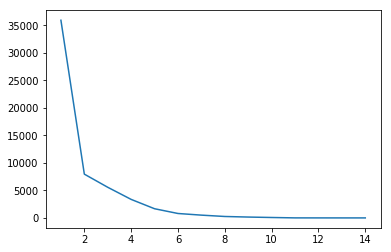

In [40]:
k_numbers = range(1, 15)
scores_for_kmeans = []
scarborough_grouped_clustering = scarborough_grouped.drop('Neighborhood', 1)

for kclusters in k_numbers:

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scarborough_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    scores_for_kmeans.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(k_numbers, scores_for_kmeans)

The optimal value of K seems around 6 for this case.

In [41]:
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(scarborough_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 4, 0, 3, 0, 2, 4, 1, 0, 0], dtype=int32)

In [42]:
kmeans.inertia_

806.3395916052206

In [43]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1, inplace=True)
except:
    pass
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

scarborough_merged = scarborough_df

# merge scarborough_grouped with scarborough_data to add latitude/longitude for each neighborhood
scarborough_merged = scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# removing anomalus entry
scarborough_merged.drop(['M1X'], inplace=True)
scarborough_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
PostalCode,,,,,,,,,,,,,,,
M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,4.0,Fast Food Restaurant,Vietnamese Restaurant,Hobby Shop,Grocery Store,General Entertainment,Fried Chicken Joint,Electronics Store,Department Store,Cosmetics Shop,Convenience Store
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,4.0,Moving Target,Bar,Vietnamese Restaurant,Grocery Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Department Store,Cosmetics Shop
M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0.0,Intersection,Electronics Store,Rental Car Location,Breakfast Spot,Pizza Place,Medical Center,Mexican Restaurant,Vietnamese Restaurant,Coffee Shop,Fried Chicken Joint
M1G,Scarborough,Woburn,43.770992,-79.216917,4.0,Coffee Shop,Korean Restaurant,Pharmacy,Vietnamese Restaurant,Clothing Store,General Entertainment,Fried Chicken Joint,Fast Food Restaurant,Electronics Store,Department Store
M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3.0,Thai Restaurant,Athletics & Sports,Bakery,Bank,Fried Chicken Joint,Lounge,Caribbean Restaurant,Hakka Restaurant,Convenience Store,Grocery Store


Plotting the Neighborhood on the map for better visual understanding

In [44]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[43.7634618, -79.368819], zoom_start=11)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(scarborough_merged['Latitude'], scarborough_merged['Longitude'], scarborough_merged['Neighborhood'], scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [45]:
scarborough_sorted.head(3)

,Neighborhood,Restaurant Likes,Total Likes
PostalCode,,,
M1T,"Clarks Corners,Sullivan,Tam O'Shanter",85.0,100.0
M1H,Cedarbrae,69.0,90.0
M1P,"Dorset Park,Scarborough Town Centre,Wexford He...",64.0,77.0


## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of restaurants in Scarborough not all of them are very popular. Highest concentration of restaurants was detected near Clarks Corners,Sullivan,Tam O'Shanter. Other borough identified as potentially interesting are Cedarbrae and Dorset Park,Scarborough Town Centre,Wexford Heights.

## Conclusion <a name="conclusion"></a>


Purpose of this project was to identify Scarborough areas with popular restaurants in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. By finding the number of likes for different Venues from Foursquare data we have identified Neighborhood that satisfy our basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.